<a href="https://colab.research.google.com/github/bmanav26/Coronary-Artery-disease-prediction/blob/main/CAD_Self_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
from sklearn.datasets import load_files
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3, VGG16
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from tensorflow.keras.optimizers import Adam, Adadelta, Nadam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from glob import glob
from tqdm import tqdm
from random import shuffle
import os, os.path
import imageio
import math
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import class_weight
import cv2
import keras_tuner as kt

In [27]:
image_dest_dir = "/content/drive/MyDrive/SPECT_MPI_Dataset"

In [28]:
dir_list_1 = (os.listdir(image_dest_dir))
dir_list_1

['ValidationSet', 'TestSet', 'TrainSet']

In [29]:
valid_dir_path = image_dest_dir+'/'+dir_list_1[0]
test_dir_path = image_dest_dir+'/'+dir_list_1[1]
train_dir_path = image_dest_dir+'/'+dir_list_1[2]

In [30]:
os.listdir(train_dir_path)

['Normal', 'Abnormal']

In [31]:
for i in range(len(dir_list_1)):
    dir_list_2 = os.listdir(image_dest_dir+'/'+dir_list_1[i])
print(dir_list_2)

['Normal', 'Abnormal']


In [32]:
print("\t\tTrain DataSet")
print("CT scans with normal            : " + str(len(os.listdir(train_dir_path+'/'+dir_list_2[0]))))
print("CT scans with abnormal          : " + str(len(os.listdir(train_dir_path+'/'+dir_list_2[1]))))

print("\n\t\tTest DataSet")
print("CT scans with normal            : " + str(len(os.listdir(test_dir_path+'/'+dir_list_2[0]))))
print("CT scans with abnormal          : " + str(len(os.listdir(test_dir_path+'/'+dir_list_2[1]))))

print("\n\t\tvalid DataSet")
print("CT scans with normal            : " + str(len(os.listdir(valid_dir_path+'/'+dir_list_2[0]))))
print("CT scans with abnormal          : " + str(len(os.listdir(valid_dir_path+'/'+dir_list_2[1]))))

		Train DataSet
CT scans with normal            : 28
CT scans with abnormal          : 100

		Test DataSet
CT scans with normal            : 7
CT scans with abnormal          : 25

		valid DataSet
CT scans with normal            : 7
CT scans with abnormal          : 25


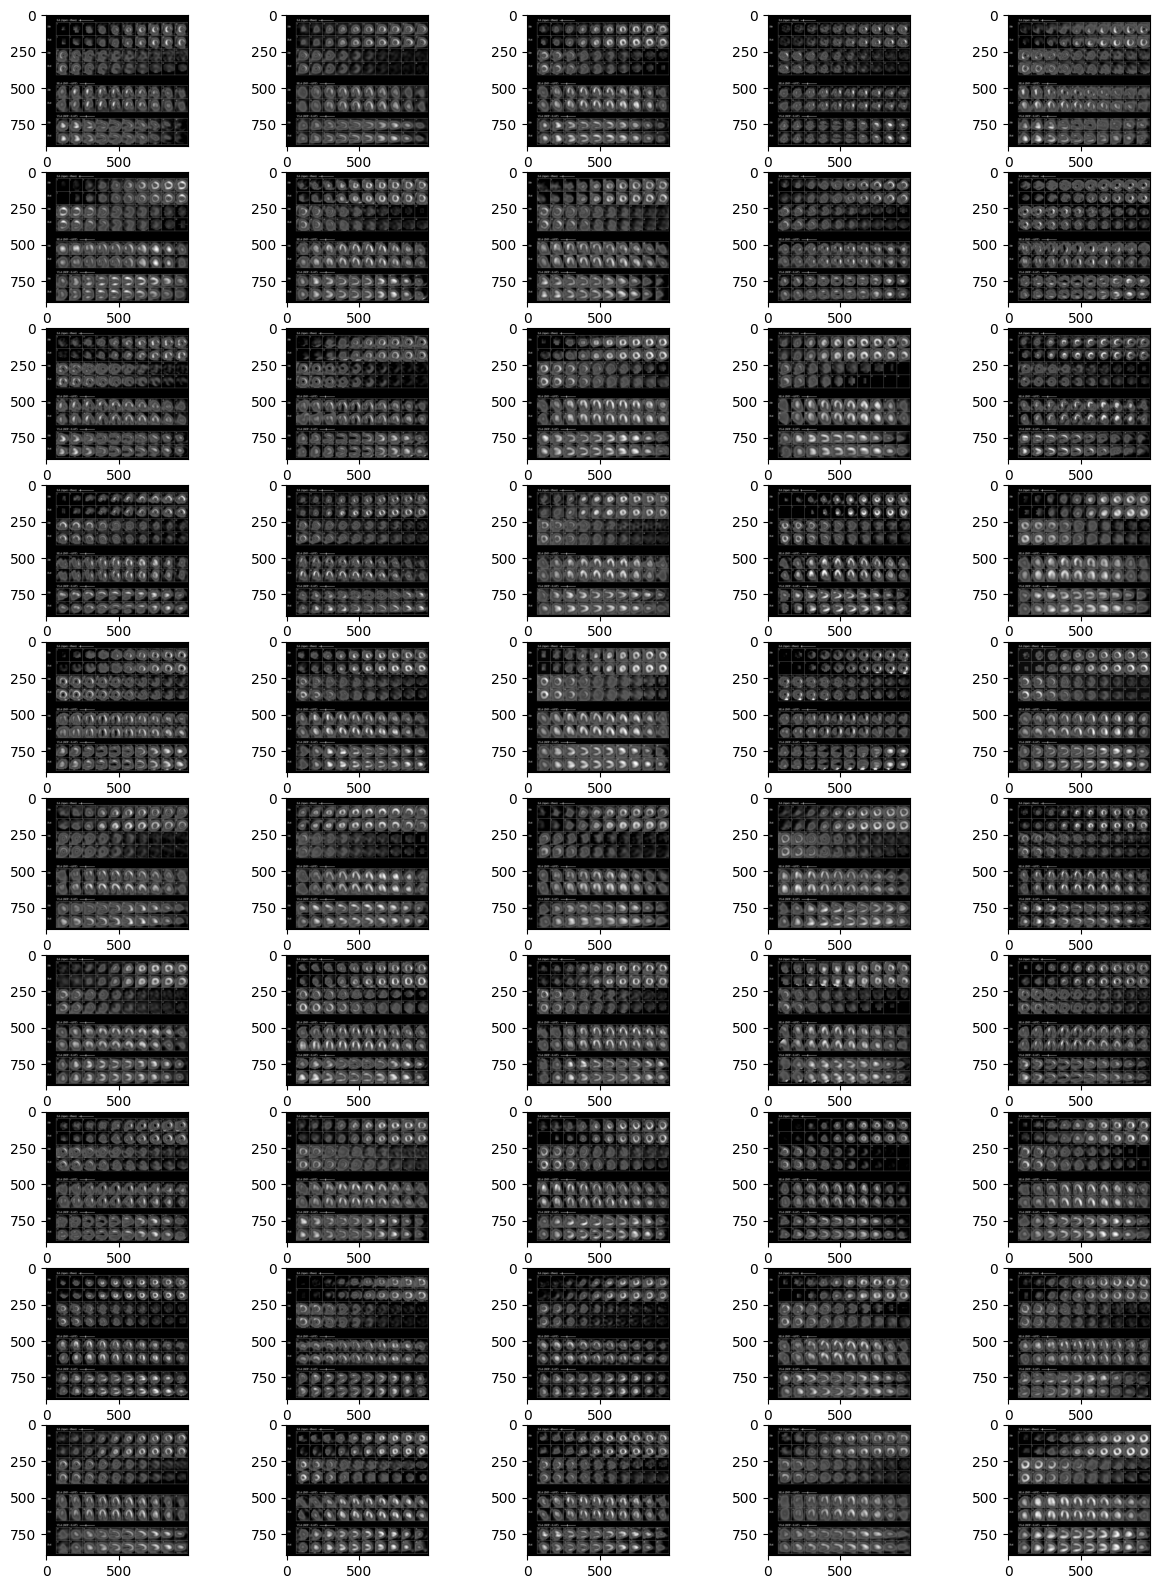

In [33]:
train_image_list = os.listdir(train_dir_path+'/'+dir_list_2[1])

w=10
h=10
fig=plt.figure(figsize=(15 , 20))
columns = 5
rows = 10
for i in range(columns*rows):
    path = train_dir_path +'/'+dir_list_2[1]+"/"+train_image_list[i]
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # print(img.dtype)
    # img = img.astype(np.float32)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap="gray")
plt.show()

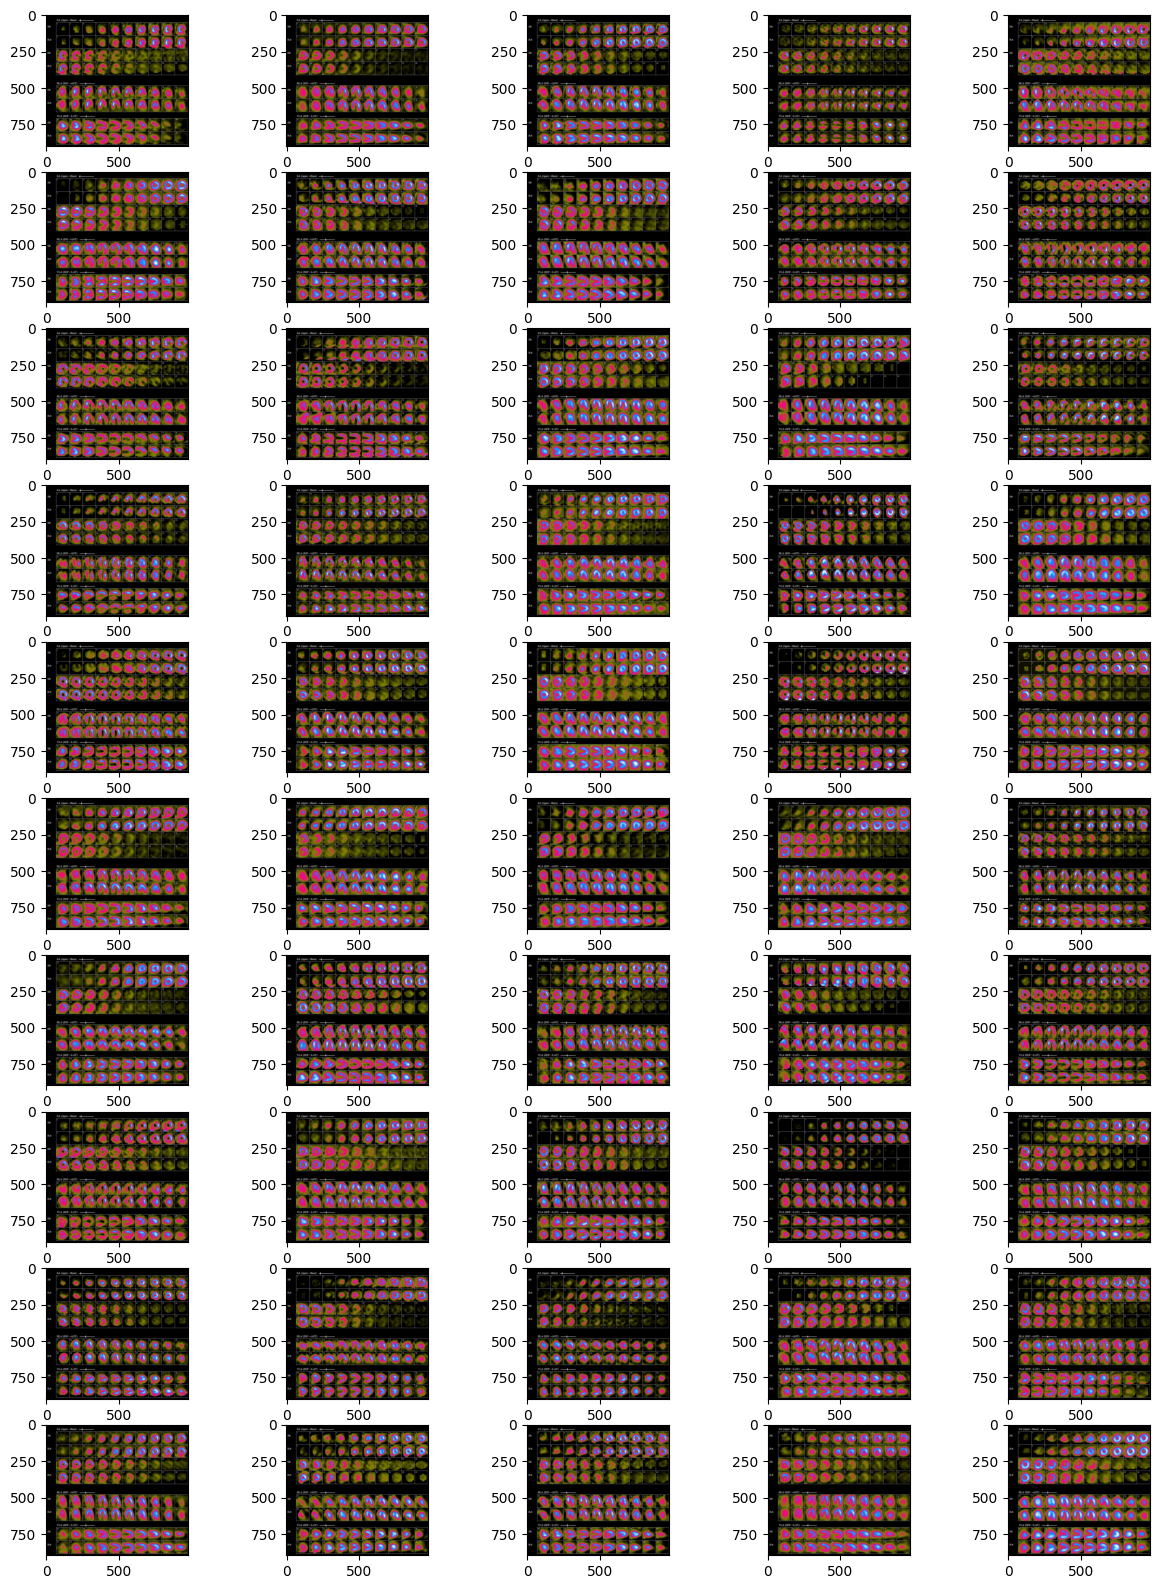

In [34]:
train_image_list = os.listdir(train_dir_path+'/'+dir_list_2[1])

w=10
h=10
fig=plt.figure(figsize=(15 , 20))
columns = 5
rows = 10
for i in range(1, columns*rows+1):
    path = train_dir_path+'/'+dir_list_2[1]+'/' + train_image_list[i-1]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    # print(img.dtype)
    # img = img.astype(np.float32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

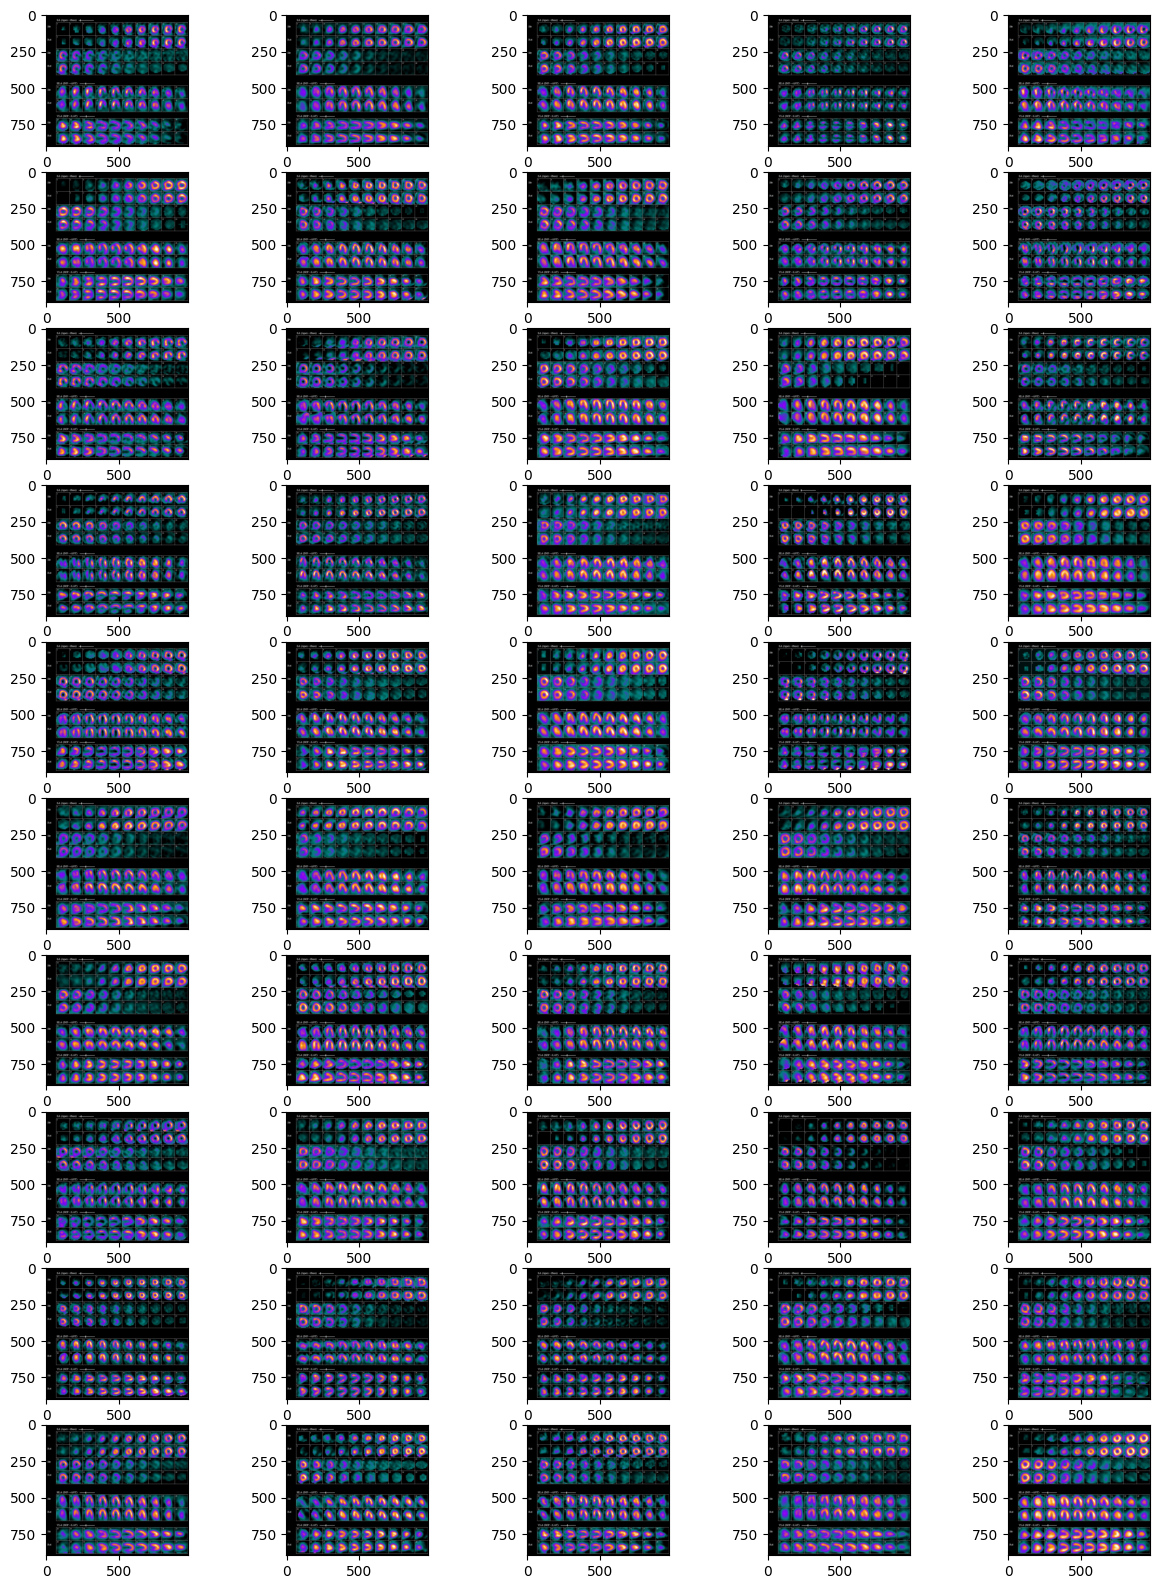

In [35]:
train_image_list = os.listdir(train_dir_path+'/'+dir_list_2[1])

w=10
h=10
fig=plt.figure(figsize=(15 , 20))
columns = 5
rows = 10
for i in range(1, columns*rows +1):
    path = train_dir_path+'/'+dir_list_2[1]+"/" + train_image_list[i-1]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [36]:
image_width = 256
image_height = 256
# print(K)
if K.image_data_format() == 'channels_first':
    input_shape = (3,  image_height, image_width,)
else:
    input_shape = (image_height, image_width, 3)
input_shape

(256, 256, 3)

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0, # this performs min-max normalization
    shear_range=0.20,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [38]:
train_generator = train_datagen.flow_from_directory(
        train_dir_path,
        target_size=(image_height, image_width),
        batch_size=8,
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        # save_to_dir=None,
        # save_prefix='copy',
        # save_format='jpg',
        # classes=None,
        # seed=None,
        # follow_links=False,
        # subset=None,
        # interpolation='nearest',
        # keep_aspect_ratio=False
        )

Found 128 images belonging to 2 classes.


In [39]:
class_weights = class_weight.compute_class_weight(
                class_weight = 'balanced',
                classes = np.unique(train_generator.classes),
                y=train_generator.classes)
for cls in train_generator.classes:
    #print(cls)
    class_weights[cls]
class_weights_1 = { 0 : class_weights[0] , 1 : class_weights[1] }

In [40]:
class_weights_1

{0: 0.64, 1: 2.2857142857142856}

In [41]:
validation_generator = train_datagen.flow_from_directory(
        valid_dir_path,
        target_size=(image_height, image_width),
        batch_size=8,
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
)

Found 32 images belonging to 2 classes.


In [42]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def fmed(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    fmed = 2 * (spec * sens)/(spec+sens+K.epsilon())
    return fmed

def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [43]:
def macro_f1(y_true, y_pred):
     return f1_score(y_true, y_pred, average='macro')

In [44]:
shape = (256, 256, 3)

In [53]:
def generate_model(hp):
    model = Sequential()
    counter = 0
    units = hp
    for i in range(hp.Int('num_layers_conv2d', min_value=1, max_value=10)):
        if(counter==0):
          model.add(
            Conv2D(
              filters=hp.Int('filter'+str(i), min_value=8, max_value=256),
              kernel_size=(3, 3),
              strides=(1,1),
              padding="same",
              activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'leaky_relu', 'elu', 'selu']),
              input_shape=input_shape
          ))
        else:
          model.add(
              Conv2D(
                  filters=hp.Int('filter'+str(i), min_value=8, max_value=256),
                  kernel_size=(3, 3),
                  strides=(1,1),
                  padding='same',
                  activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'leaky_relu', 'elu', 'selu'])
          ))

        model.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=None))
        counter+=1

    model.add(Flatten())

    for i in range(hp.Int('num_layers_dense', min_value=1, max_value=10)):
        model.add(
          Dense(hp.Int('units' + str(i), min_value=8, max_value=256),
          activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'leaky_relu', 'elu', 'selu']),
          ))
        model.add(Dropout(hp.Choice('dropout'+str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd', 'nadam', 'adadelta']),
                  loss='binary_crossentropy',
                  metrics=['accuracy', sensitivity, specificity, fmed, f1])

    return model

In [54]:
tuner = kt.RandomSearch(generate_model,
                        objective = 'val_accuracy',
                        max_trials=3,
                        directory="mydir1",
                        project_name="Model")

In [55]:
tuner.search(train_generator, epochs=10, validation_data=validation_generator)

Trial 3 Complete [00h 01m 01s]
val_accuracy: 0.78125

Best val_accuracy So Far: 0.78125
Total elapsed time: 00h 02m 45s


In [57]:
tuner.get_best_hyperparameters()[0].values

{'num_layers_conv2d': 6,
 'filters0': 169,
 'activation0': 'leaky_relu',
 'num_layers_dense': 1,
 'dense_units0': 93,
 'dropout0': 0.1,
 'optimizer': 'rmsprop',
 'conv2d_units1': 8,
 'activation1': 'relu',
 'conv2d_units2': 8,
 'activation2': 'relu',
 'conv2d_units3': 8,
 'activation3': 'relu',
 'conv2d_units4': 8,
 'activation4': 'relu',
 'conv2d_units5': 8,
 'activation5': 'relu'}

In [59]:
model=tuner.get_best_models(num_models=1)[0]

In [62]:
num_train_samples = 128
num_validation_samples = 32
batch_size = 8

In [64]:
model_history=model.fit(
    train_generator,
    steps_per_epoch=num_train_samples//batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation_samples//batch_size,
    verbose=1,
    epochs=1000,
    initial_epoch=11,
    callbacks=[
        EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=15,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=20
        )
    ],
    class_weight = class_weights_1
)

Epoch 12/1000
16/16 [==============================] - 7s 414ms/step - loss: 0.6935 - accuracy: 0.2188 - sensitivity: 0.8125 - specificity: 0.0000e+00 - fmed: 0.0000e+00 - f1: 0.3391 - val_loss: 0.6958 - val_accuracy: 0.2188 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_fmed: 0.0000e+00 - val_f1: 0.3475
Epoch 13/1000
16/16 [==============================] - 4s 272ms/step - loss: 0.6936 - accuracy: 0.2188 - sensitivity: 0.8750 - specificity: 0.0000e+00 - fmed: 0.0000e+00 - f1: 0.3404 - val_loss: 0.6963 - val_accuracy: 0.2188 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_fmed: 0.0000e+00 - val_f1: 0.3556
Epoch 14/1000
16/16 [==============================] - 6s 375ms/step - loss: 0.6936 - accuracy: 0.2109 - sensitivity: 0.9062 - specificity: 0.0000e+00 - fmed: 0.0000e+00 - f1: 0.3301 - val_loss: 0.6955 - val_accuracy: 0.2188 - val_sensitivity: 0.7500 - val_specificity: 0.0000e+00 - val_fmed: 0.0000e+00 - val_f1: 0.3222
Epoch 15/1000
16/16 [================

dict_keys(['loss', 'accuracy', 'sensitivity', 'specificity', 'fmed', 'f1', 'val_loss', 'val_accuracy', 'val_sensitivity', 'val_specificity', 'val_fmed', 'val_f1'])


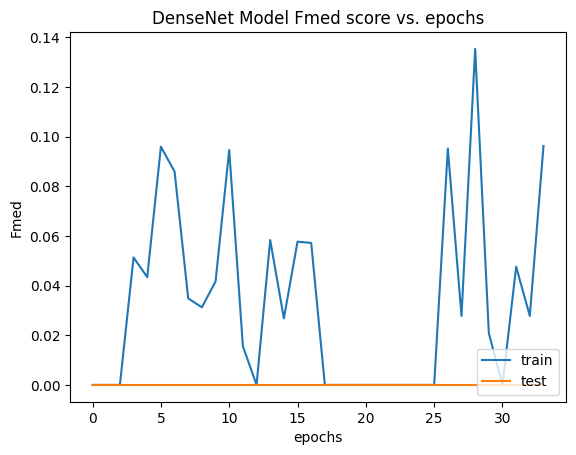

In [65]:
history = model_history
print(history.history.keys())

# summarize history for fmed score - DenseNet
plt.plot(history.history['fmed'])
plt.plot(history.history['val_fmed'])
plt.title('DenseNet Model Fmed score vs. epochs')
plt.ylabel('Fmed')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

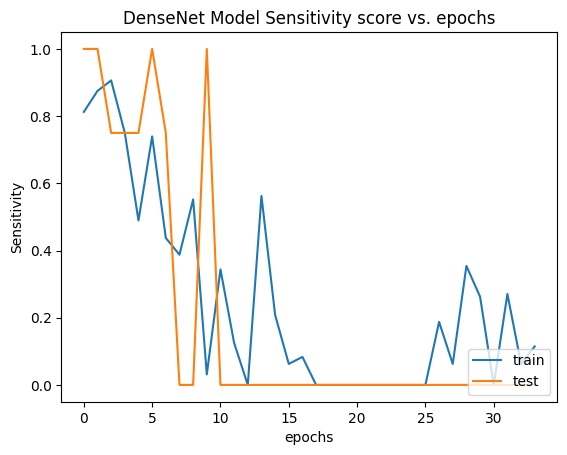

In [66]:
# summarize history for sensitivity score
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('DenseNet Model Sensitivity score vs. epochs')
plt.ylabel('Sensitivity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

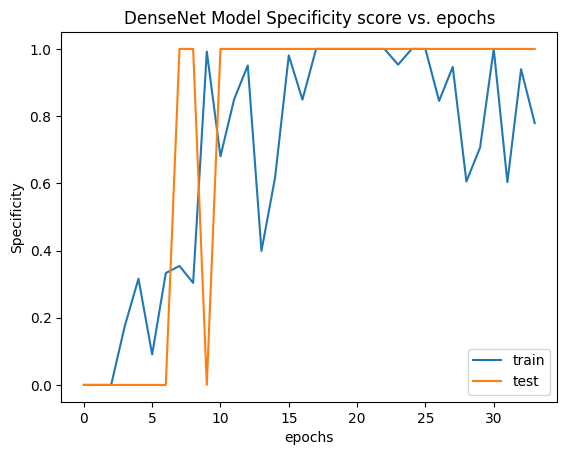

In [67]:
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('DenseNet Model Specificity score vs. epochs')
plt.ylabel('Specificity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

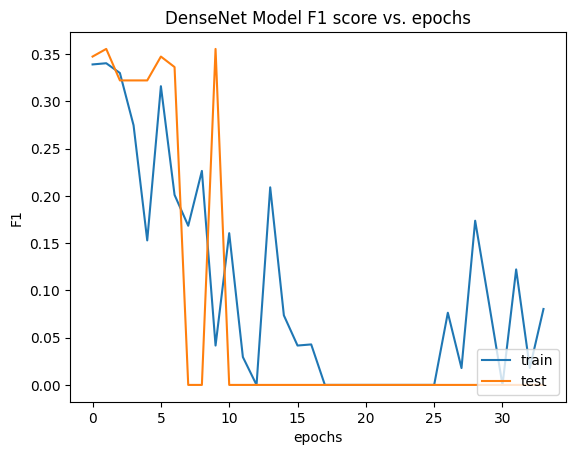

In [68]:
# summarize history for f1 score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('DenseNet Model F1 score vs. epochs')
plt.ylabel('F1')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


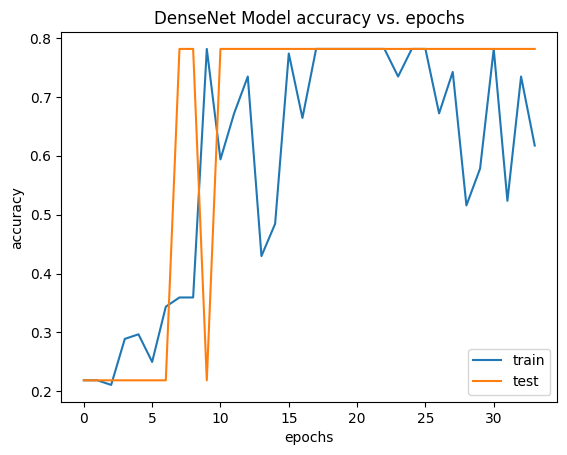

In [69]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet Model accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

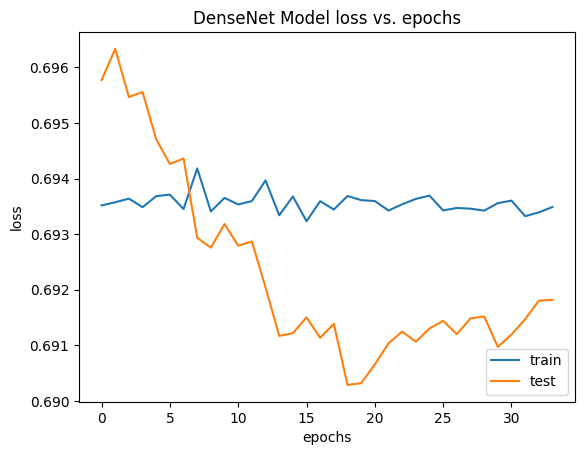

In [70]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet Model loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [71]:
test_generator = train_datagen.flow_from_directory(
        test_dir_path,
        target_size=(image_height, image_width),
        batch_size=32,
        color_mode="rgb",
        class_mode='binary',
        shuffle=False,
        seed=42
)

Found 32 images belonging to 2 classes.


In [ ]:
model = generate_model()